100%|██████████| 4460/4460 [06:58<00:00, 10.66it/s]


Epoch 0 Loss: 3.2044285891301962
Epoch 0 Loss: 2.824110276816672
Epoch 0 Train Loss: 3.2044285891301962, Valid Loss: 2.824110276816672


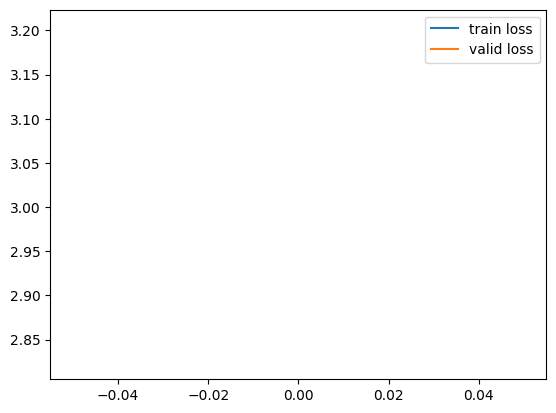

KeyError: 'y'

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from typing import List
from tqdm import tqdm
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Tokenizer:
    def __init__(
        self,
        dataPath:str
        ):
        with open(dataPath,"r",encoding="utf-8") as f:
            self.dataset = f.read()
        self.generate_vocabulary()

    def generate_vocabulary(
        self,
        ):

        unique_chars = sorted(set(self.dataset))
        self.char2index = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # start tokens from 1
        self.char2index['<pad>'] = 0  # padding token
        self.index2char = {idx: char for char, idx in self.char2index.items()}

    def encode(
        self,
        sentence : str,
        ) -> torch.Tensor:
        """
        TODO:
        例子, 假设A-Z 对应的token是1-26, 句子开始，结束符号的token是0。
        input  : "ABCD"
        output : Tensor([0,1,2,3]) 

        注意: 为了后续实验方便，输出Tensor的数据类型dtype 为torch.long。
        """
        tokens = [self.char2index.get(char, 0) for char in sentence]
        return torch.tensor(tokens, dtype=torch.long)

    def decode(
        self,
        tokens : torch.Tensor,
        ) -> str:
        """
        TODO:
        例子, 假设A-Z 对应的token是1-26, 句子开始，结束符号的token是0。
        input : Tensor([0,1,2,3]) 
        output : "ABCD"
        """
        sentence = ''.join([self.index2char[token] for token in tokens])
        return sentence
    
class ShakespeareDataset(Dataset):
    def __init__(self, filepath, tokenizer, chunk_size):
        self.tokenizer = tokenizer
        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
        text = text[: int(len(text) / 20)]
        self.encoded = self.tokenizer.encode(text)
        self.chunk_size = chunk_size

    def __len__(self):
        return len(self.encoded) - self.chunk_size

    def __getitem__(self, idx):
        #TODO: 提取一段文本(长度为 chunk_size）作为输入，以及这段文本的每一个字符的下一个字符作为标签
        # example(not correspond to real text): chunk = tensor([ 0, 20, 49, 58, 59])
        #                                       label = tensor([20, 49, 58, 59, 19])
        # decoded chunk: "The "
        # decoded label: "he T"
        chunk = self.encoded[idx:idx + self.chunk_size]
        label = self.encoded[idx + 1:idx + self.chunk_size + 1]
        
        return chunk, label

class HeadAttention(nn.Module):

    def __init__(self, seq_len:int, embed_size:int, hidden_size:int):
        super().__init__()
        # embed_size: dimension for input embedding vector
        # hidden_size: dimension for hidden vector. eg. x:(..., embed_size) --to_q--> query_vector:(..., hidden_size)

        # TODO: init three matrix, to_q, to_k, to_v.
        self.seq_len = seq_len
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        
        # 初始化权重矩阵
        self.to_q = nn.Linear(embed_size, hidden_size)
        self.to_k = nn.Linear(embed_size, hidden_size)
        self.to_v = nn.Linear(embed_size, hidden_size)

        nn.init.xavier_uniform_(self.to_q.weight)
        nn.init.xavier_uniform_(self.to_k.weight)
        nn.init.xavier_uniform_(self.to_v.weight)
        # a triangular bool matrix for mask
        self.register_buffer("tril", torch.tril(torch.ones(seq_len, seq_len)))
        

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size)
        # return (batch_size, seq_len, hidden_size)
        # TODO: implement the attention mechanism
        inputs.to(device)
        # 计算 query, key, value
        query = self.to_q(inputs)  # (batch_size, seq_len, hidden_size)
        key = self.to_k(inputs)    # (batch_size, seq_len, hidden_size)
        value = self.to_v(inputs)  # (batch_size, seq_len, hidden_size)
        
        # 计算注意力分数
        # Q 和 K 的乘积
        scores = torch.bmm(query, key.transpose(1, 2))  # (batch_size, seq_len, seq_len)
        
        # 对 scores 进行缩放处理
        scores = scores / (self.hidden_size ** 0.5)
        
        # 对 scores 进行屏蔽，将上三角部分置为负无穷，避免模型在注意力计算时泄露未来信息
        scores = scores.masked_fill(self.tril == 0, float('-inf'))
        
        # 对 scores 进行 softmax 操作，得到注意力权重
        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, seq_len, seq_len)
        
        # 将注意力权重与 value 相乘得到注意力输出
        attention_output = torch.bmm(attention_weights, value).to(inputs.device)  # (batch_size, seq_len, hidden_size)
        
        return attention_output 

class MultiHeadAttention(nn.Module):
    # MultiHeadAttention is consist of many HeadAttention output.
    # concat all this head attention output o_i, then merge them with a projection matrix W_o, as [o_1, o_2, ...] x W_o
    # The reason for using multi-head attention is that we want each head to be able to extract different features
    def __init__(self, n_heads:int, head_size:int, seq_len:int, embed_size:int):
        # n_heads is the number of head attention
        # head_size is the hidden_size in each HeadAttention
        super().__init__()
        self.n_heads = n_heads
        self.head_size = head_size
        self.seq_len = seq_len
        self.embed_size = embed_size

        
        # Calculate head_size
        head_size = embed_size // n_heads
        
        # Initialize multiple HeadAttention instances
        self.heads = nn.ModuleList([
            HeadAttention(seq_len, embed_size, head_size) for _ in range(n_heads)
            ])
        
        # Projection matrix
        self.projection = nn.Linear(n_heads * head_size, embed_size)
        nn.init.xavier_uniform_(self.projection.weight)
        
    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size), make sure embed_size=n_heads x head_size
        # return: (batch_size, seq_len, embed_size)
        # TODO:
        inputs.to(device)
        head_outputs = [
            head(inputs) for head in self.heads
            ]  # List of tensors of shape (batch_size, seq_len, head_size)
        
        # Concatenate along the feature dimension
        concatenated = torch.cat(head_outputs, dim=-1)  # (batch_size, seq_len, n_heads * head_size)
        
        # Project back to embed_size
        projected = self.projection(concatenated).to(inputs.device)  # (batch_size, seq_len, embed_size)
        
        return projected

class Expert(nn.Module):
    def __init__(self, embed_size:int):
        super().__init__()
        #TODO: init two linear layer
        self.linear1 = nn.Linear(embed_size, 4 * embed_size)
        self.linear2 = nn.Linear(4 * embed_size, embed_size)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)

    def forward(self, inputs):
        # inputs: (batch_size, seq_len, embed_size)
        # -> mid: (batch_size, seq_len, 4 * embed_size)
        # -> outputs: (batch_size, seq_len, embed_size)
        inputs.to(device)
        mid = self.linear1(inputs)  # (batch_size, seq_len, 4 * embed_size)
        mid = F.relu(mid)  # 使用ReLU作为非线性变换
        
        outputs = self.linear2(mid).to(inputs.device)  # (batch_size, seq_len, embed_size)
        
        return outputs

class TopkRouter(nn.Module):
    def __init__(self, embed_size, num_experts, active_experts):
        super().__init__() 
        ## TODO
        ## embed_size : dimension of embedding 
        ## num_experts : how many Experts per layer
        ## active_experts: only active_experts out of num_experts are selected to process Embeddings per token.
        self.embed_size = embed_size
        self.num_experts = num_experts
        self.active_experts = active_experts
        
        # MLP for computing scores
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, num_experts)
        )

    def forward(self, inputs):
        ## TODO
        ## 完成这部分时，注意使用Softmax()对router_output做标准化。同时注意这部分所用操作的可导性。
        ## 输入值
        ## inputs is the output tensor from multihead self attention block, shape (B:batch size, T: seq_len, C: embed_size)
        ## 返回值
        ## router_output: normalized weight of Experts, 即教程中的 \alpha
        ## indices:   index of selected Experts, 即教程中的 index
        inputs.to(device)
        score = self.mlp(inputs)
        _ , indices = torch.topk(score, self.active_experts, dim=-1)
        mask = torch.zeros_like(score, dtype=torch.bool)
        mask.scatter_(dim=-1, index=indices, value=True)

        score = score.masked_fill(~mask, float("-inf"))
        router_output = F.softmax(score, dim=-1).to(inputs.device)
        return router_output, indices
    

class SparseMoE(nn.Module):
    def __init__(self, embed_size:int, num_experts:int, active_experts:int):
        super().__init__()
        self.embed_size = embed_size
        self.num_experts = num_experts
        self.active_experts = active_experts
        
        # Initialize TopkRouter and Experts
        self.router = TopkRouter(embed_size, num_experts, active_experts)
        self.experts = nn.ModuleList([Expert(embed_size) for _ in range(num_experts)])
        
        # Softmax layer for combining outputs from active experts
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):
        inputs.to(device)
        # inputs: (batch_size, seq_len, embed_size)
        
        # Get routing information from TopkRouter
        router_output, indices = self.router(inputs)  # router_output: (batch_size, seq_len, num_experts), indices: (batch_size, seq_len, active_experts)
        
        # Initialize output tensor
        batch_size, seq_len, embed_size = inputs.size()
        final_output = torch.zeros_like(inputs).to(inputs.device)
        
        # Iterate through each token and apply selected experts
        for i in range(batch_size):
            for j in range(seq_len):
                selected_experts = [self.experts[idx] for idx in indices[i, j]]  # Select experts based on indices
                selected_weights = router_output[i, j, indices[i, j]]  # Weights corresponding to selected experts
                
                # Compute weighted sum of outputs from selected experts
                expert_outputs = torch.cat([expert(inputs[i:i+1, j:j+1, :]) for expert in selected_experts], dim=0)  # List to tensor
                weighted_sum = torch.sum(expert_outputs * selected_weights.view(-1, 1, 1), dim=0)
                
                # Assign to final output tensor
                final_output[i, j, :] = weighted_sum
        
        return final_output

class Block(nn.Module):
    # Transformer basic block, consist of MultiHeadAttention, FeedForward and layer normalization
    def __init__(self, embed_size:int, n_heads:int, seq_len:int, num_experts:int, active_experts:int):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(embed_size)
        self.layernorm2 = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(
            n_heads, embed_size // n_heads, seq_len, embed_size
        )
        self.moe = SparseMoE(embed_size, num_experts, active_experts)

    def forward(self, inputs):
        x = self.layernorm1(inputs)
        x = x + self.attention(x)
        x = self.layernorm2(x)
        x = x + self.moe(x)
        return x

class SparseMoETransformer(nn.Module):
    def __init__(self, vocab_size:int, seq_len:int, embed_size:int, n_layers:int, n_heads:int, num_experts:int, active_experts:int):
        super().__init__()
        self.seq_len = seq_len
        self.embed_size = embed_size
        
        # Token embedding and position embedding
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(seq_len, embed_size)
        
        # Stack of Transformer blocks
        self.blocks = nn.ModuleList([
            Block(embed_size, n_heads, seq_len, num_experts, active_experts) 
            for _ in range(n_layers)
        ])
        
        # Layer normalization and output linear layer
        self.layernorm = nn.LayerNorm(embed_size)
        self.output_linear = nn.Linear(embed_size, vocab_size)
        nn.init.xavier_uniform_(self.output_linear.weight)

    def forward(self, inputs, labels=None):
        batch_size, seq_len = inputs.shape
        
        # Token and position embeddings
        token_embeddings = self.token_embedding(inputs)  # (batch_size, seq_len, embed_size)
        position_indices = torch.arange(seq_len, device=inputs.device)
        position_embeddings = self.position_embedding(position_indices)  # (1, seq_len, embed_size)
        
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        
        # Pass through the stack of Transformer blocks
        x = embeddings
        for i, block in enumerate(self.blocks):
            x = block(x)
        
            # Layer normalization and linear layer
        x = self.layernorm(x)
        logits = self.output_linear(x)  # (batch_size, seq_len, vocab_size)
        
        if labels is None:
            loss = None
        else:
            batch_size, seq_len, vocab_size = logits.shape
            logits = logits.view(batch_size * seq_len, vocab_size)
            labels = labels.view(batch_size * seq_len)
            loss = F.cross_entropy(logits, labels)
        return logits, loss
    
    def generate(self, inputs, max_new_tokens):
        inputs = torch.tensor(tokenizer.encode(inputs)).unsqueeze(0)
        device = next(self.parameters()).device  
        inputs = inputs.to(device)
        if inputs.size(1) > self.seq_len:
            inputs = inputs[:, :self.seq_len]
        generated = inputs
        for _ in range(max_new_tokens):
            if generated.size(1) > self.seq_len:
                generated_input = generated[:, -self.seq_len:]
            else:
                generated_input = generated
            
            
            logits, _ = self.forward(generated_input)
            last_logits = logits[:, -1, :]  
            next_token_ids = torch.argmax(last_logits, dim=-1)  
            next_token_ids = next_token_ids.unsqueeze(-1)  
            generated = torch.cat([generated, next_token_ids], dim=1)
        return generated

    
def train(model, dataloader, epoch, device):
    # Optimizer 会根据模型的输出和真实标签计算梯度，然后利用反向传播算法更新模型的参数。
    # 在本实验中你可以将 Optimizer 视作黑盒，只需要知道如何使用即可。
    # 找一个合适的 Optimizer。对不同的任务，模型，最适合的优化器是不一样的，你可以先尝试最常用的 Adam，如果有兴趣可以看看其他的优化器。
    # docs see: https://pytorch.org/docs/stable/optim.html 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # 选择 Adam 作为优化器
    model.train()
    total_loss = 0
    
    for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.clone().detach()
        targets = targets.clone().detach()
        optimizer.zero_grad()
        logits, loss = model(inputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch} Loss: {avg_loss}')
    
    return avg_loss


def validate(model, dataloader, epoch, device):
    model.eval()

    total_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        logits, loss = model(inputs, targets)
        total_loss += loss.item()
    print(f"Epoch {epoch} Loss: {total_loss / len(dataloader)}")
    return total_loss / len(dataloader)




def create_dataloader(filepath, tokenizer, chunk_size, batch_size, shuffle=True):
    dataset = ShakespeareDataset(filepath, tokenizer, chunk_size)
    train_dataset,val_dataset = torch.utils.data.random_split(dataset,[int(len(dataset)*0.8),len(dataset)-int(len(dataset)*0.8)])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    return train_dataloader, val_dataloader

def run(model, train_dataloader, valid_dataloader, device, epochs=0):
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss = train(model, train_dataloader, epoch, device)
        valid_loss = validate(model, valid_dataloader, epoch, device)
        print(f"Epoch {epoch} Train Loss: {train_loss}, Valid Loss: {valid_loss}")
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    return train_losses, valid_losses


def plot_loss(train_loss, valid_loss):
    plt.plot(train_loss, label="train loss")
    plt.plot(valid_loss, label="valid loss")
    plt.legend()
    plt.show()


tokenizer = Tokenizer(dataPath="input.txt")

train_dataloader, val_dataloader = create_dataloader(
    "input.txt",
    tokenizer,
    chunk_size=20,
    batch_size=10,
)

model = SparseMoETransformer(
                vocab_size=len(tokenizer.char2index), 
                seq_len=20, 
                embed_size=16, 
                n_layers=1, 
                n_heads=1, 
                num_experts=1, 
                active_experts=1
        ).to(device)

model.to(device)

train_losses, valid_losses = run(
    model, train_dataloader, val_dataloader, device, epochs=1
)

plot_loss(train_losses, valid_losses)

# 保存模型
torch.save(model.state_dict(), 'model.pth')

model.load_state_dict(torch.load('model.pth'))

print(
    tokenizer.decode(
        model.generate("I could pick my lance",max_new_tokens=100)[0].tolist()
    )
)

